In [10]:
%load_ext autoreload
%autoreload 2

# Load packages
import numpy as np
import sde_solvers as sde
from scipy import stats
import matplotlib.pyplot as plt
import imports.stochastic_plots as stoch
import imports.arrival_process_simulation as arrival

_ = plt.rcParams['figure.figsize'] = (10, 6)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Important note

The plotting fuctions created for this assigment have been slightly changed, and a new plotting function (`plot_trajectories_jump_diffusion`) has been added to the `stochastic_plots.py` file. It is important that this new version of the file is in the `imports` folders. It just be just like that when the projects is uncompressed from the given zip file.

# Euler integration scheme for ODE's

In [11]:
def ode_euler(t0, x0, T, a, N):

    dT = T / N # size of simulation step
    
    # Initialize solution array
    t = np.linspace(t0, t0+T, N+1) # integration grid
    X = np.zeros(N+1)
    
    # Initial condition
    X[0] = x0
 
    # Integration of the ODE
    for n in range(N):
        X[n+1] = X[n] + a(t[n], X[n])*dT
        
    return (t, X)

# Integration schemes for SDE's

In [12]:
# Define SDE
mu = 1.3
sigma = 0.4
def a(t,x): return mu*x
def b(t,x): return sigma*x
def db_dx(t,x): return sigma

# Define initial conditions
t0, x0 = 0.0, 100.0
# Define the simulation parameters 
M = 10000 # Number of trajectories for simulation
T = 2.0   # Length of simulation interval
N = 1000  # Number of steps in simulation

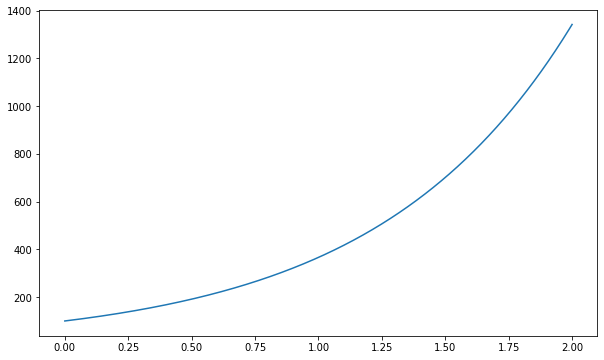

In [13]:
t, X_mean = ode_euler(t0, x0, T, a, N)
_ = plt.plot(t, X_mean)

## Stochastic Euler integration (Euler- Maruyana) scheme

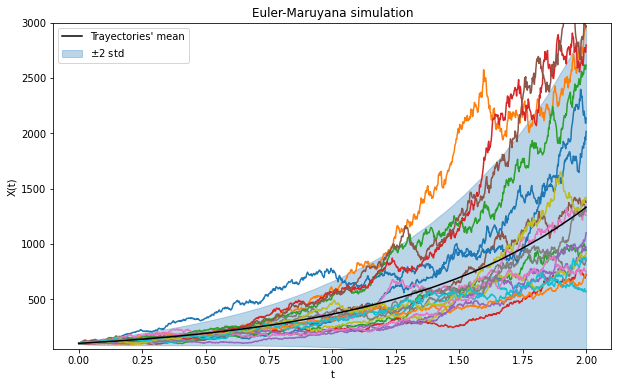

In [14]:
# Carry out simulation
t, X_euler = sde.euler_maruyana(t0, x0, T, a, b, M, N)
y_max = min(np.max(X_euler), 3000)
 
# Plot trajectories 
stoch.plot_trajectories(t, X_euler, fig_num=1)

sde.subplot_mean_and_std(t, np.mean(X_euler, axis=0),
                         2*np.std(X_euler, axis=0),
                         ylims=[np.min(X_euler), y_max],
                         color='black')
plt.legend(['Trayectories\' mean', '$\pm$2 std'])
_ = plt.title('Euler-Maruyana simulation')

## Milstein integration sheme

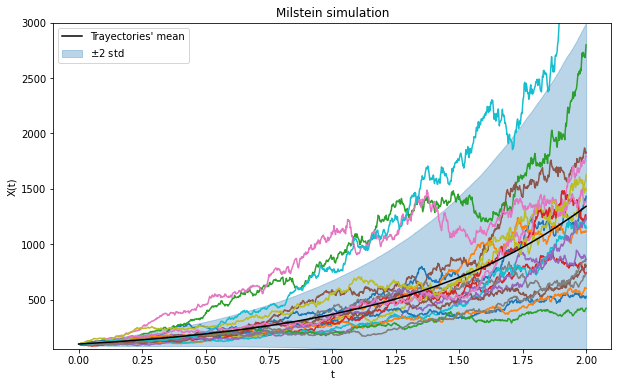

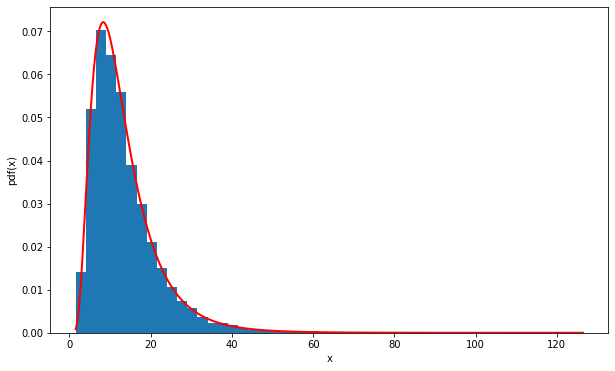

In [15]:
t, X_milstein = sde.milstein(t0, x0, T, a, b, db_dx, M, N)
y_max = min(np.max(X_milstein), 3000)
            
# Plot trajectories
stoch.plot_trajectories(t, X_milstein, fig_num=1)
sde.subplot_mean_and_std(t, np.mean(X_milstein, axis=0),
                         2*np.std(X_milstein, axis=0),
                         ylims=[np.min(X_milstein), y_max], color='black')
plt.legend(['Trayectories\' mean', '$\pm$2 std'])
plt.title('Milstein simulation')

# Plot histogram
xT = X_milstein[:,-1]
def pdf(x): return stats.lognorm.pdf(x, 
                           sigma*np.sqrt(T), 0.0, np.exp((mu - 0.5*sigma**2)*T))
stoch.plot_pdf(xT/x0, pdf, fig_num=2)

## Jump simulator

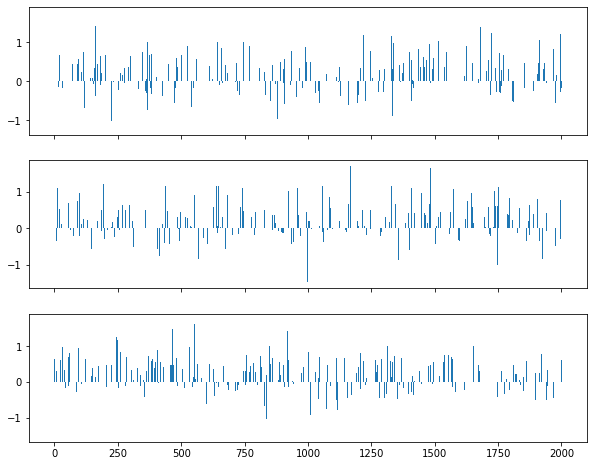

In [22]:
lambda_rate = 0.5
beta_scale = 1.0/lambda_rate 
def simulator_arrival_times(t0, T): 
    return  arrival.simulate_poisson(t0, t0 + T, lambda_rate, M = 1)[0]
def simulator_jump_sizes(N): return 0.2 + 0.5*np.random.randn(N)

def simulator_jump_process(t0, T, M):
    return sde.simulate_jump_process(t0, T,
                                     simulator_arrival_times, 
                                     simulator_jump_sizes, 
                                     M)

t0 = 0.0
T = 2000.0
M = 3
times_of_jumps, sizes_of_jumps = simulator_jump_process(t0, T, M)

fig, axs = plt.subplots(M, sharex=True, num=1, figsize=(10, 8))
for m in range(M):
     axs[m].bar(times_of_jumps[m], sizes_of_jumps[m])

## Jump-diffusion SDE

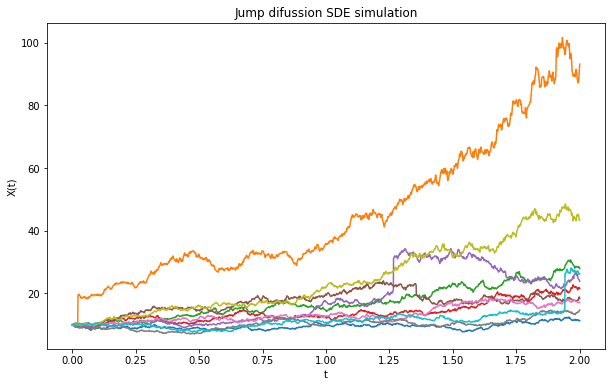

In [48]:
## Define jump-diffusion SDE
def a(t,x): return 5.0*x/x0
def b(t,x): return 3.0*x/x0
def c(t,x): return 10.0*x/x0

## Define the conditions for the simulation

t0 = 0
x0 = 10.0
T = 2.0
N = 1000
M = 500

t, X = sde.euler_jump_diffusion(t0, x0, T, a, b, c, 
                         simulator_jump_process, 
                         M, N)

max_trajectories = 10
stoch.plot_trajectories_jump_diffusion(t, X, max_trajectories=max_trajectories,
                                       fig_num=10)
_ = plt.title('Jump difussion SDE simulation')